# Data Science Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb

#########################################
# Custom Attention Layer for DL Model
#########################################
class Attention(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)
    
    def call(self, x):
        # x shape: (batch_size, time_steps, features)
        e = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        a = K.softmax(e, axis=1)               # (batch_size, time_steps, 1)
        output = x * a                         # (batch_size, time_steps, features)
        return K.sum(output, axis=1)           # (batch_size, features)

#########################################
# Preprocessing Function
#########################################
def preprocess(df, is_train=True):
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['quarter'] = df['date'].dt.quarter
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

#########################################
# Load and Preprocess Data
#########################################
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocess(train, is_train=True)
test = preprocess(test, is_train=False)

# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# Scale features
scaler_X = StandardScaler()
X_train_full = scaler_X.fit_transform(X_train_full)
X_test = scaler_X.transform(X_test)

# Log transform target variable
y = np.log1p(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

#########################################
# Deep Learning Model with Attention & Residual Connection
#########################################
inputs = Input(shape=(X_train.shape[1],))
# Main branch
x = Dense(256)(inputs)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Expand dims to simulate a "time" dimension for attention
x_expanded = Lambda(lambda t: K.expand_dims(t, axis=1))(x)  # (batch, 1, features)
attn_out = Attention()(x_expanded)  # (batch, features)

# Residual branch
residual = Dense(64)(inputs)
residual = LeakyReLU(alpha=0.1)(residual)

# Combine branches
combined = Add()([attn_out, residual])
combined = Dense(32)(combined)
combined = LeakyReLU(alpha=0.1)(combined)
combined = BatchNormalization()(combined)

outputs = Dense(1)(combined)
model_dl = Model(inputs, outputs)

# Compile DL model
model_dl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mae')

# Callbacks for DL model
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train DL model
history_dl = model_dl.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate DL model on validation set
y_val_pred_dl = model_dl.predict(X_val).flatten()
y_val_pred_dl = np.expm1(y_val_pred_dl)  # reverse log transform

#########################################
# XGBoost Model
#########################################
# Prepare DMatrix for XGBoost; note: we use the original scaled features and log target
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Set parameters for XGBoost (tune as needed)
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 7,
    'seed': 42
}

# Train XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, 'val')], early_stopping_rounds=10, verbose_eval=False)

# Predict using XGBoost on validation set and reverse log transform predictions
y_val_pred_xgb = xgb_model.predict(dval)
y_val_pred_xgb = np.expm1(y_val_pred_xgb)

#########################################
# Ensemble Predictions (Weighted Average)
#########################################
# You can adjust weights; here, 0.5/0.5 is a simple average
weight_dl = 0.5
weight_xgb = 0.5

y_val_pred_ens = weight_dl * y_val_pred_dl + weight_xgb * y_val_pred_xgb

val_mape_ens = mean_absolute_percentage_error(np.expm1(y_val), y_val_pred_ens)
print(f"Validation Ensemble MAPE: {val_mape_ens:.4f}")

#########################################
# Final Predictions on Test Set
#########################################
# Deep Learning predictions
test_pred_dl = model_dl.predict(X_test).flatten()
test_pred_dl = np.expm1(test_pred_dl)
# XGBoost predictions
test_pred_xgb = xgb_model.predict(dtest)
test_pred_xgb = np.expm1(test_pred_xgb)

# Ensemble predictions
test_pred_ens = weight_dl * test_pred_dl + weight_xgb * test_pred_xgb
test_pred_ens = np.maximum(test_pred_ens, 0)

# Save submission
test_ids = test['id']
submission = pd.DataFrame({"id": test_ids, "quantity": test_pred_ens})
submission.to_csv("submission_ensemble.csv", index=False)
print("Predictions saved to submission_ensemble.csv")


C:\Users\yuvraj.singh\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 10.0365 - val_loss: 10.2111 - learning_rate: 5.0000e-04
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.5992 - val_loss: 10.3907 - learning_rate: 5.0000e-04
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9362 - val_loss: 8.5089 - learning_rate: 5.0000e-04
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0299 - val_loss: 7.6375 - learning_rate: 5.0000e-04
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8381 - val_loss: 5.5026 - learning_rate: 5.0000e-04
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4259 - val_loss: 3.8664 - learning_rate: 5.0000e-04
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7453 - val_loss: 2.2183 - learning_rate: 5.0000e-04
Epoch 8/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0133 - val_loss: 0.7005 - learning_rate: 5.0000e-04
Epoch 9/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8688 - val_loss: 0.6381 - lea

Validation MAPE: 0.0825
Validation MAE: 2284.0975
Validation RMSE: 3377.1403


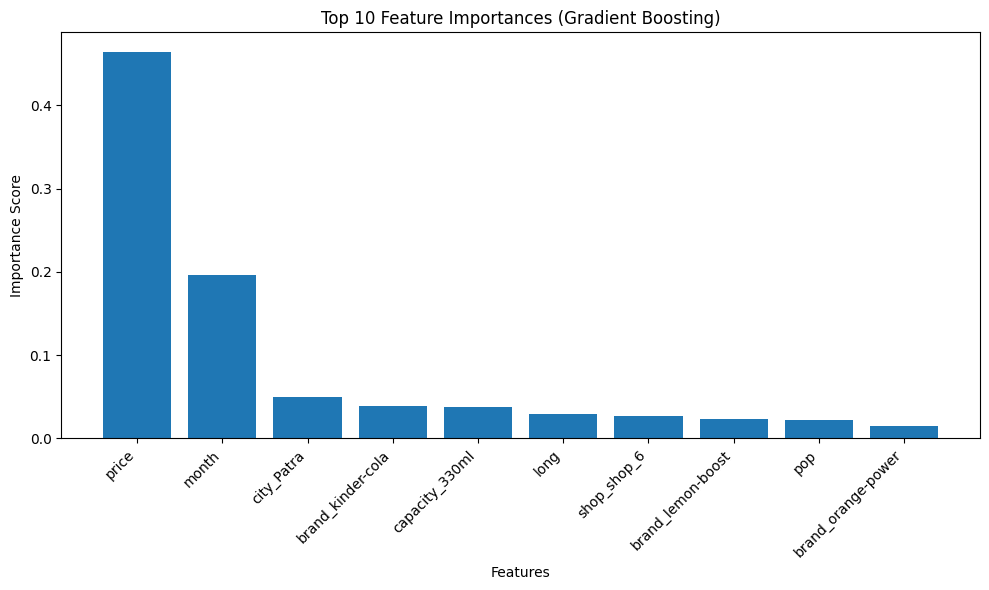

Predictions saved to submission_gbr_final.csv


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Function to preprocess data
def preprocess(df, is_train=True):
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    # Fill missing numerical values with median
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    # Fill missing categorical values with mode
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

# Load and preprocess train and test data
train = preprocess(pd.read_csv("train.csv"), is_train=True)
test = preprocess(pd.read_csv("test.csv"), is_train=False)

# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
# Align test features with training features and fill any remaining NaNs
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)
X_test = X_test.fillna(0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

# Plot feature importance using the model's attribute
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_full.columns

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), [features[i] for i in indices][:10], rotation=45, ha='right')
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Predict on test set and save submission
test_ids = test['id']
test_pred = model.predict(X_test)
test_pred = np.maximum(test_pred, 0)  # Ensure non-negative predictions
submission = pd.DataFrame({"id": test_ids, "quantity": test_pred})
submission.to_csv("submission_gbr_final.csv", index=False)
print("Predictions saved to submission_gbr_final.csv")


In [17]:
#!pip install pandas==2.2.3 numpy==1.26.4 scikit-learn==1.6.1 xgboost==2.1.4 matplotlib==3.10.1
#OR
#import sys
#!{sys.executable} -m pip install pandas==2.2.3 numpy==1.26.4 scikit-learn==1.6.1 xgboost==2.1.4 matplotlib==3.10.1

In [15]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("XGBoost version:", xgb.__version__)
print("Matplotlib version:", matplotlib.__version__)


Pandas version: 2.2.3
NumPy version: 1.26.4
Scikit-Learn version: 1.6.1
XGBoost version: 2.1.4
Matplotlib version: 3.10.1


Validation MAPE: 0.0835
Validation MAE: 2323.0319
Validation RMSE: 3479.3784


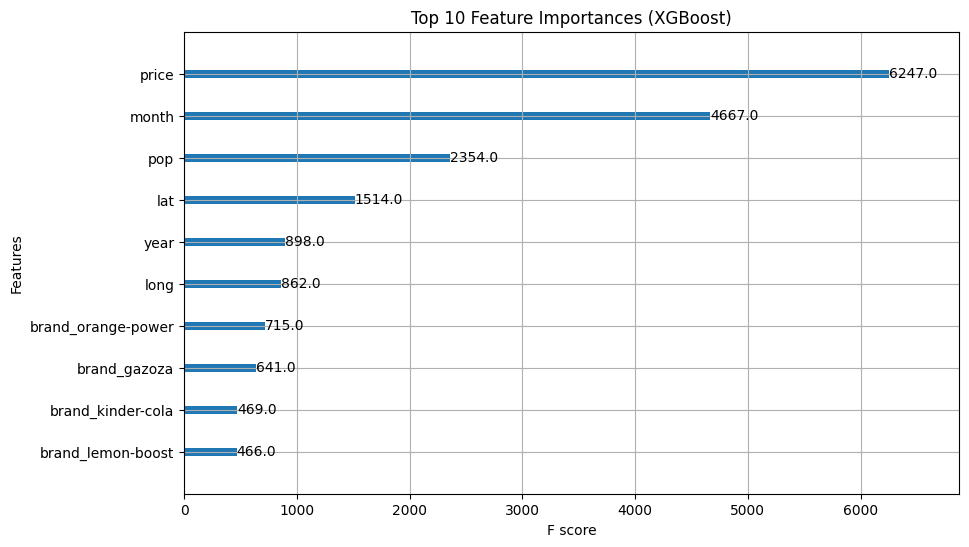

Predictions saved to submission_xgb_short.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Function to preprocess data
def preprocess(df, is_train=True):
    # Convert date and extract year and month
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    # Fill missing numerical values
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    # Fill missing categorical values
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

# Load and preprocess train and test data together
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocess(train, is_train=True)
test = preprocess(test, is_train=False)

# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
# Align test features with training features
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=7, n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, max_num_features=10, ax=ax)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

# Predict on test set and save submission
test_ids = test['id']
test_pred = model.predict(X_test)
test_pred = np.maximum(test_pred, 0)  # Ensure non-negative predictions
submission = pd.DataFrame({"id": test_ids, "quantity": test_pred})
submission.to_csv("submission_xgb_short.csv", index=False)
print("Predictions saved to submission_xgb_short.csv")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best CV MAPE (on original scale): 0.072462


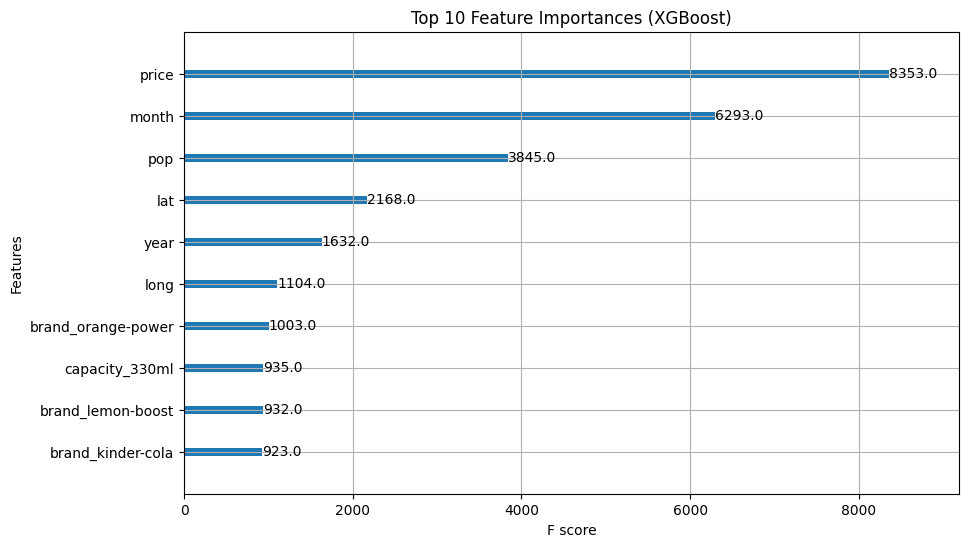

Predictions saved to submission_xgb_log_cv.csv


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

# Function to preprocess data
def preprocess(df, is_train=True):
    # Convert date and extract year and month
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    # Fill missing numerical values
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    # Fill missing categorical values
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

# Load and preprocess train and test data together
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocess(train, is_train=True)
test = preprocess(test, is_train=False)

# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
# Align test features with training features
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# Apply log transformation to target variable to stabilize variance
y_log = np.log1p(y)  # log1p(x) = log(x + 1) to handle zero values

# Define a custom MAPE scorer for GridSearchCV
def mape_exp(y_true, y_pred_log):
    # Convert log-scale predictions back to original scale
    y_pred = np.expm1(y_pred_log)
    y_true_exp = np.expm1(y_true)
    return mean_absolute_percentage_error(y_true_exp, y_pred)

mape_scorer = make_scorer(mape_exp, greater_is_better=False)

# Define the XGBoost model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with log-transformed target variable
grid_search = GridSearchCV(xgb_reg, param_grid, scoring=mape_scorer, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train_full, y_log)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best CV MAPE (on original scale): {-grid_search.best_score_:.6f}")

# Train final model on the entire dataset
best_model.fit(X_train_full, y_log)

# Predict on test set (back-transform predictions to original scale)
test_pred_log = best_model.predict(X_test)
test_pred = np.expm1(test_pred_log)  # Convert back to original scale
test_pred = np.maximum(test_pred, 0)  # Ensure non-negative predictions

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(best_model, max_num_features=10, ax=ax)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

# Save predictions
submission = pd.DataFrame({"id": test['id'], "quantity": test_pred})
submission.to_csv("submission_xgb_log_cv.csv", index=False)
print("Predictions saved to submission_xgb_log_cv.csv")


Validation MAPE: 0.0922
Validation MAE: 2468.7067
Validation RMSE: 3516.3066


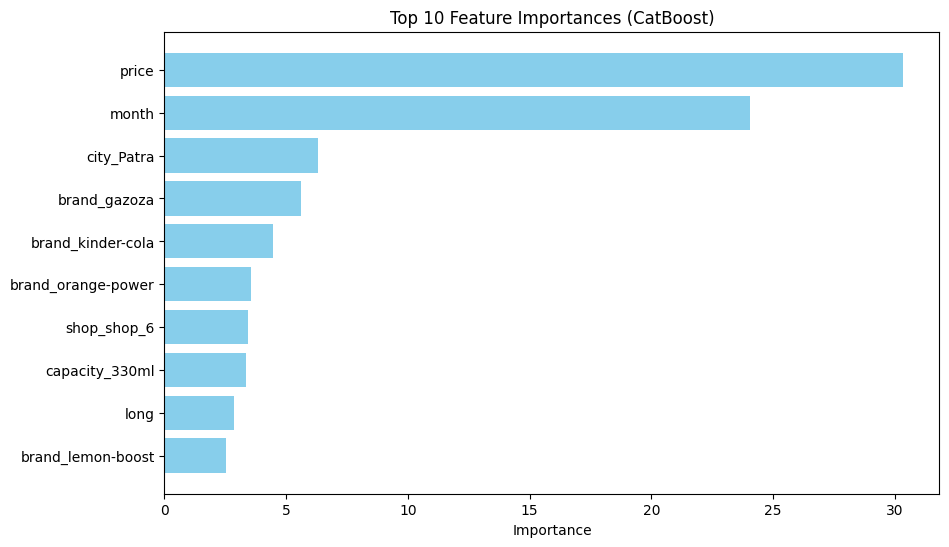

Predictions saved to submission_catboost_short.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Function to preprocess data
def preprocess(df, is_train=True):
    # Convert date and extract year and month
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    # Fill missing numerical values
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    # Fill missing categorical values
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

# Load and preprocess train and test data together
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocess(train, is_train=True)
test = preprocess(test, is_train=False)

# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
# Align test features with training features
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

# Train CatBoost regressor
model = CatBoostRegressor(
    loss_function='RMSE',
    learning_rate=0.1,
    depth=7,
    iterations=200,
    random_seed=42,
    verbose=0  # Suppress CatBoost's logging output
)
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

# Plot feature importance
feature_importances = model.get_feature_importance()
features = X_train_full.columns

# Create a DataFrame for feature importances and select top 10 features
feat_imp_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
top_features = feat_imp_df.sort_values(by='importance', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_features['feature'], top_features['importance'], color='skyblue')
ax.invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (CatBoost)")
plt.show()

# Predict on test set and save submission
test_ids = test['id']
test_pred = model.predict(X_test)
test_pred = np.maximum(test_pred, 0)  # Ensure non-negative predictions
submission = pd.DataFrame({"id": test_ids, "quantity": test_pred})
submission.to_csv("submission_catboost_short.csv", index=False)
print("Predictions saved to submission_catboost_short.csv")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 5184, number of used features: 23
[LightGBM] [Info] Start training from score 29384.871914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Validation MAPE: 0.0894
Validation MAE: 2411.0167
Validation RMSE: 3492.7703


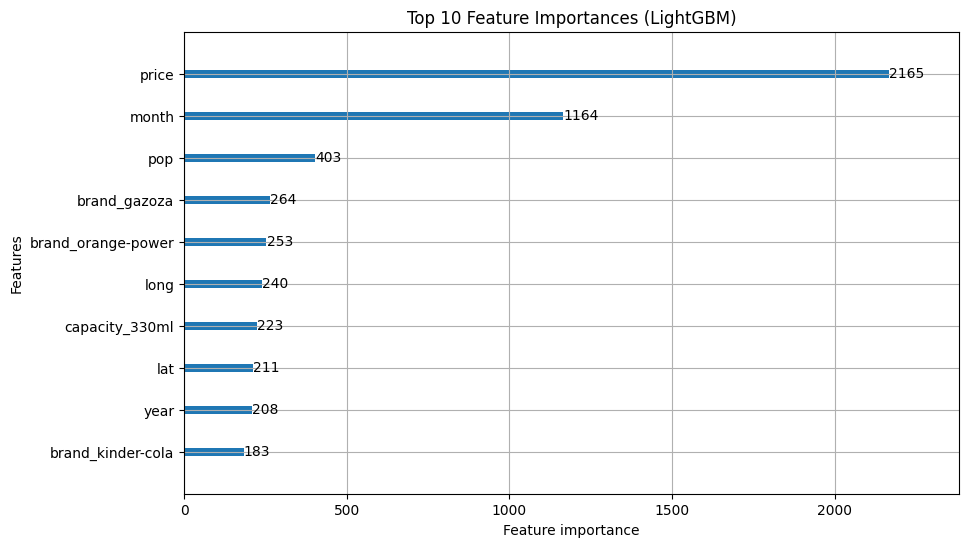

Predictions saved to submission_lightgbm_short.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Function to preprocess data
def preprocess(df, is_train=True):
    # Convert date and extract year and month
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    # Fill missing numerical values
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    # Fill missing categorical values
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

# Load and preprocess train and test data together
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocess(train, is_train=True)
test = preprocess(test, is_train=False)

# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
# Align test features with training features
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

# Train LightGBM regressor
model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

# Plot feature importance using LightGBM's built-in function
ax = lgb.plot_importance(model, max_num_features=10, figsize=(10, 6))
plt.title("Top 10 Feature Importances (LightGBM)")
plt.show()

# Predict on test set and save submission
test_ids = test['id']
test_pred = model.predict(X_test)
test_pred = np.maximum(test_pred, 0)  # Ensure non-negative predictions
submission = pd.DataFrame({"id": test_ids, "quantity": test_pred})
submission.to_csv("submission_lightgbm_short.csv", index=False)
print("Predictions saved to submission_lightgbm_short.csv")


In [1]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

## Data Description

Column | Description
:---|:---
`id` | Unique Identifier
`brand` | The brand name of the product
`capacity` | The volume of each container (lt/ml)
`city`| The name of the city for each shop 
`container`| The type (nature) of the container.
`date`| Date of sale
`lat`| The latitude of the shop
`long`| The longitude of the shop
`pop` | Population of the city (assumed constant)
`shop` | the shop id
`price`| The average monthly price of the corresponding container (in US `$$`)
`quantity` | The number of containers sold in a month (target variable)

## Data Wrangling & Visualization

In [3]:
data = pd.read_csv('train.csv', index_col=0)

In [4]:
data.head()

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
id,,,,,,,,,,,
0.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [5]:
#Explore columns
data.columns

Index(['date', 'city', 'lat', 'long', 'pop', 'shop', 'brand', 'container',
       'capacity', 'price', 'quantity'],
      dtype='object')

In [6]:
#Description
data.describe()

,lat,long,pop,price,quantity
count,6429.000000,6434.000000,6480.000000,6480.000000,6480.000000
mean,38.301238,23.270246,355141.416667,1.188981,29431.855093
std,1.649771,1.086960,232828.796289,0.814567,17901.328301
min,35.327870,21.734440,134219.000000,0.110000,2953.000000
25%,37.962450,22.417610,141439.750000,0.610000,16441.750000
50%,38.244440,22.930860,257501.500000,0.920000,25184.000000
75%,39.636890,23.716220,665871.000000,1.500000,37866.000000
max,40.643610,25.143410,672130.000000,4.540000,145287.000000


In [7]:
# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'], format="%d/%m/%y", errors='coerce')

# Extract year and month
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month


In [8]:
# Fill missing values
for col in ['lat', 'long', 'pop', 'price']:
    data[col] = data[col].fillna(data[col].median())
for col in ['brand', 'capacity', 'container', 'city', 'shop']:
    data[col] = data[col].fillna(data[col].mode()[0])


In [9]:
# Drop unnecessary columns
data.drop(columns=['date'], inplace=True)

# Remove rows with missing target variable
data = data.dropna(subset=['quantity'])

# Define features and target
X = data.drop(columns=['quantity'])
y = data['quantity']


In [10]:
# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'city', 'container', 'shop']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_features = encoder.fit_transform(X[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

# Split dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_valid)
mape_score = mean_absolute_percentage_error(y_valid, y_pred)
print(f"MAPE: {mape_score:.4f}")

# Feature Importance Analysis
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_20_features = feature_importances.nlargest(20)

MAPE: 0.1239


## Visualization, Modeling, Machine Learning

Can you predict future demand and identify how different features influence that? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of mean absolute percent error.**
- **Read the Test.csv file and prepare features for testing.**

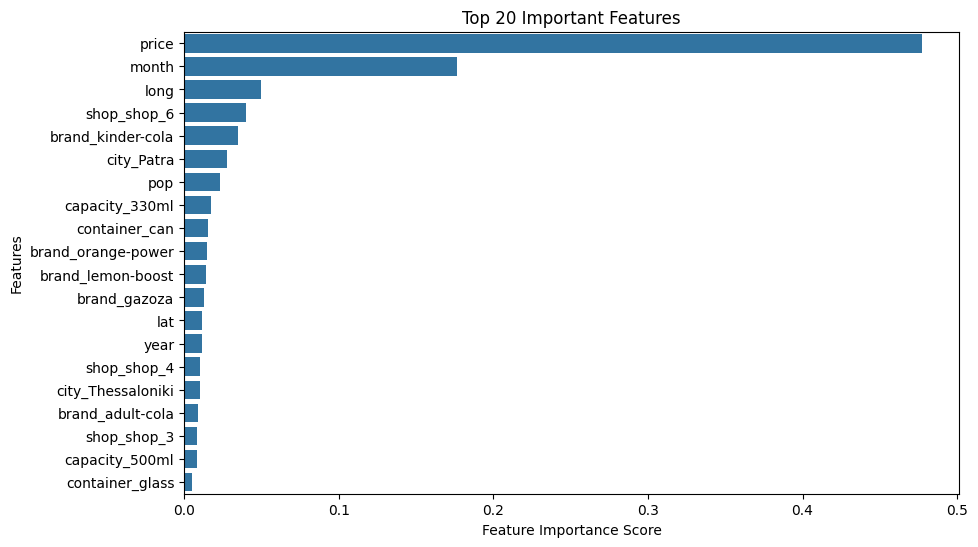

In [11]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_features, y=top_20_features.index)
plt.title("Top 20 Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

In [12]:

# Load test data
test_data = pd.read_csv("test.csv")

# Convert date column to datetime format
test_data['date'] = pd.to_datetime(test_data['date'], format="%d/%m/%y", errors='coerce')

# Extract year and month
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month

In [13]:
# Fill missing values
for col in ['lat', 'long', 'pop', 'price']:
    test_data[col] = test_data[col].fillna(test_data[col].median())
for col in ['brand', 'capacity', 'container', 'city', 'shop']:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Drop unnecessary columns and save IDs
test_ids = test_data['id']
test_data.drop(columns=['id', 'date'], inplace=True)

In [14]:
# One-hot encode test categorical variables
encoded_test_features = encoder.transform(test_data[categorical_cols])
encoded_test_df = pd.DataFrame(encoded_test_features, columns=encoder.get_feature_names_out(categorical_cols))
test_data = pd.concat([test_data.drop(columns=categorical_cols), encoded_test_df], axis=1)

# Predict on test data
test_predictions = model.predict(test_data)



**The management wants to know what are the most important features for your model.  Can you tell them?**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


> #### Task:
- **Submit the predictions on the test dataset using your optimized model.** <br/>
    For each record in the test set (`Test.csv`), you must predict the value of the `quantity` variable. You should submit a CSV file with a header row and one row per test entry. 
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **quantity**

In [15]:
#Submission
submission = pd.DataFrame({'id': test_ids, 'quantity': test_predictions})
submission.to_csv('submissions2.csv', index=False)
print("Predictions saved to submissions.csv")

Predictions saved to submissions.csv


---